In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import PolynomialFeatures

5

5

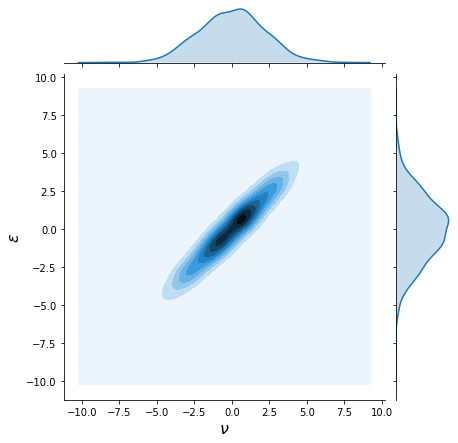

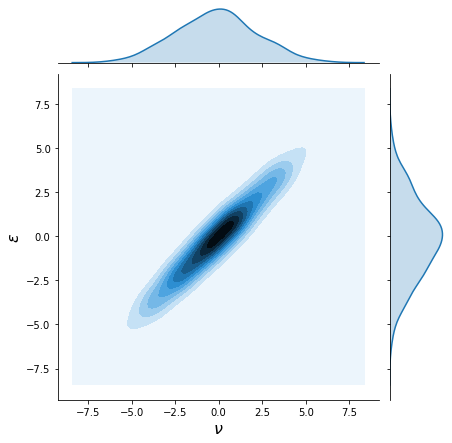

In [93]:
#Ex 6.1.1. Rewrite the below code to define a function simulate(n, m, k, plot)
def simulate(n, m, k, plot):
    cov = 5
    np.random.seed(seed=None)
    errors = np.random.multivariate_normal(mean = [0,0], cov = [[cov, cov], [cov, cov]], size = n)
    
    if plot==1:
        h = sns.jointplot(errors[:,0], errors[:,1], kind = 'kde')
        h.set_axis_labels('$\\nu$', '$\epsilon$', fontsize=16)

    z = np.random.normal(size = (n,m))
    x = np.random.normal(size = (n,k))

    # Auxilliary equation
    nu = errors[:,0]
    Pi = np.array([5] + [x if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = m - 1)])
    gamma = np.array([5] + [x if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = k - 1)])

    d = z @ Pi + x @ gamma + nu

    # Main equation
    u = errors[:,1]
    delta = np.array([5] + [x  if np.random.uniform() > 0.9 else 0 for x in np.random.uniform(low = -2, high = 5, size = k - 1)])
    alpha = np.random.uniform(1,2)

    y = alpha * d  + x @ delta + u
    
    return alpha, delta, gamma, Pi, y, d, x, z, nu, u

n = 1000  # Number of observations
m = 150   # Number of potential instruments
k = 10    # Number of covariates

plot = 1  # if plot=1 then plot

alpha, delta, gamma, Pi, y, d, x, z, nu, u = simulate(n, m, k, plot)

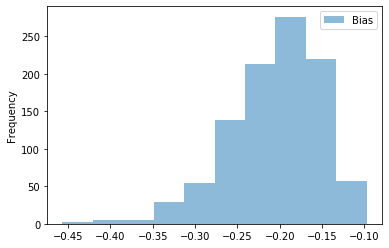

In [107]:
#Ex. 6.1.2: Use your function to simulate a new dataset and regress the following OLS regression

from statsmodels.api import OLS
from statsmodels.tools import add_constant

M = 1000  # Number of MC simulations
n = 1000  # Number of observations
m = 150   # Number of potential instruments
k = 10    # Number of covariates

plot = 0  # if plot = 1 then plot

alpha_est  = np.zeros(M)
alpha_true = np.zeros(M)
#alpha_est  = pd.DataFrame(zero_data)
#alpha_true = pd.DataFrame(zero_data)
for i in range(0,M):
    #np.random.seed(seed=i)
    alpha_true[i], delta, gamma, Pi, y, d, x, z, nu, u = simulate(n, m, k, plot)

    D = add_constant(d)

    model   = OLS(y,D)
    results = model.fit()
    est     = results.params
    alpha_est[i] = est[1]
    #results.params
    
    
diff_np = alpha_true - alpha_est
diff_pd = pd.DataFrame({'Bias': diff_np})
hist_diff = diff_pd.plot.hist(bins=10, alpha=0.5)

In [106]:
# Ex. 6.1.3:
n = 1000  # Number of observations
m = 150   # Number of potential instruments
k = 10    # Number of covariates

alpha, delta, gamma, Pi, y, d, x, z, nu, u = simulate(n, m, k, plot)


nonzero = pd.get_dummies(Pi>0)
total = nonzero.sum()   
total

False    140
True      10
dtype: int64

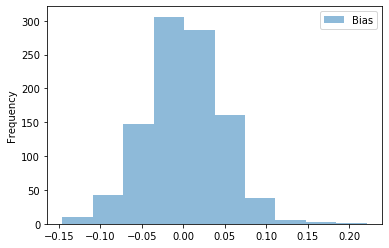

In [190]:
#Ex. 6.1.4:
M = 1000  # Number of MC simulations
n = 1000  # Number of observations
m = 150   # Number of potential instruments
k = 10    # Number of covariates

plot = 0  # if plot = 1 then plot

alpha_est  = np.zeros(M)
alpha_true = np.zeros(M)
for i in range(0,M):
    alpha_true[i], delta, gamma, Pi, y, d, x, z, nu, u = simulate(n, m, k, plot)

    d_hat = z @ Pi
    D = add_constant(d_hat)

    model   = OLS(y,D)
    results = model.fit()
    est     = results.params
    alpha_est[i] = est[1]
    #results.params
    
    
diff_np = alpha_true - alpha_est
diff_pd = pd.DataFrame({'Bias': diff_np})
hist_diff = diff_pd.plot.hist(bins=10, alpha=0.5)


In [123]:

from sklearn.linear_model import LassoCV, Lasso
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

class PostLasso:
    def __init__(self, formula = None):
        self.lasso_model = Lasso()
        self.ols_model = None
        self.relevant_x = None
        self.subset_cols = None
        self.coefs = None
        self.formula = formula
    
    def __repr__(self):
        return f'PostLasso({self.formula})'
    
    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, X, y, force_include_idx = None):
        ''' Estimate a model using Post-Lasso
        
        X: X matrix (without intercept)
        y: y vector
        force_include_idx: column indexes that ALWAYS is
            included in the OLS model, regardless of their
            status in the lasso stage.
        '''
        self.lasso_model = self.lasso_model.fit(X,y)
        self.coefs = np.insert(self.lasso_model.coef_, 0, self.lasso_model.intercept_)
        self.subset_cols = np.where(self.coefs != 0)[0]
        if force_include_idx is not None:
            self.subset_cols = np.union1d(self.subset_cols, force_include_idx)
        self.relevant_x = add_constant(X)[:,self.subset_cols]
        self.ols_model = OLS(y, self.relevant_x).fit()
        return self

    def predict(self, X = None):
        ''' Predict using a fitted post-lasso model.
        '''
        if X is None:
            return self.ols_model.predict(self.relevant_x)
        if X.shape == self.relevant_x.shape:
            return self.ols_model.predict(X)
        return self.ols_model.predict(X[:,self.subset_cols])

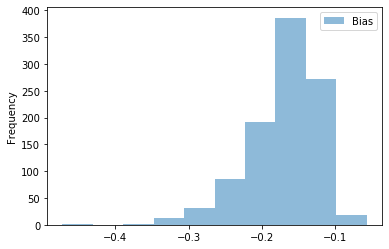

In [226]:
# Ex. 6.1.5: (må have lavet en fejl)
M = 1001  # Number of MC simulations
n = 1000  # Number of observations
m = 150   # Number of potential instruments
k = 10    # Number of covariates

force_include = np.arange(k, dtype=np.uint8)
alpha_est  = np.zeros(M)
alpha_true = np.zeros(M)
for i in range(0,M):
    alpha_true[i], delta, gamma, Pi, y, d, x, z, nu, u = simulate(n, m, k, plot)
    
    X = np.c_[x, z]

    model = PostLasso()
    model.fit(X,d,force_include)
    
    relevant_x  = model.relevant_x
    
    d_pred      = model.predict(relevant_x)

    D = np.c_[d_pred, relevant_x]

    model_ols   = OLS(y,D)
    results     = model_ols.fit()
    est         = results.params
    
    alpha_est[i] = est[0]
    
diff_np = alpha_true - alpha_est
diff_pd = pd.DataFrame({'Bias': diff_np})
hist_diff = diff_pd.plot.hist(bins=10, alpha=0.5)